<a href="https://colab.research.google.com/github/yasirrustam06/All-colab-codes/blob/main/Naive_LSTM_HyperParameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the necessary libraries
%%capture
!pip3 install --upgrade --no-cache-dir gdown
!pip3 install emoji
!pip3 install contractions
!pip3 install keras_tuner
!pip3 install transformers
!pip install Keras-Preprocessing

In [ ]:
# Import the necessary libraries
import re
import os
import pandas as pd
import xml.etree.ElementTree as ET
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import emoji
import string
import contractions

In [ ]:
# Set the notebook hyperparameter
LOAD = False
# TRAIN = False
TRAIN =True

# Data Extraction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

LOADING ANOTHER DATA

In [ ]:
df_offensive = pd.read_csv('/content/drive/MyDrive/hate_speech.csv')

In [ ]:
# Utilised functions
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)

In [ ]:
# Load the dataset into a dataframe
# path = '/content/pan21-author-profiling-training-2021-03-14/en'
path = '/content/drive/MyDrive/en'
filenames = sorted_alphanumeric(os.listdir(path))

df = pd.DataFrame(columns=['Text', 'Author', 'Truth'])

for index, filename in enumerate(tqdm(filenames)):
    if filename[-3:] == 'xml':
        root = ET.parse(path + '/' + filename).getroot()

        truth = int(root.get('class'))
        texts = root.findall('documents/document')

        for text in texts:
            df.loc[len(df)] = [text.text, index, truth]

100%|██████████| 201/201 [01:07<00:00,  2.96it/s]


In [ ]:
# Preview the dataset
print(f"Number of offensive tweets: {df[df['Truth'] == 1].shape[0]}")   #  1 for offensive speech
print(f"Number of non-offensive tweets: {df[df['Truth'] == 0].shape[0]}")


Number of offensive tweets: 20000
Number of non-offensive tweets: 20000


In [ ]:
# Utilised functions
# Normalize sequences of at least 3 repeated characters with a maximum of two letters
def replace_more_than_three(s):
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
    return pattern.sub(r"\1\1", s)

def clean_text(sentence):

    # Remove the dataset specific terms and other html leftovers
    elements = {r'#URL#': '', r'#USER#': '', r'#HASHTAG#': '', r'&amp': ' ', r'&quot': '', r'&apos': '',
                r'&lt': '', r'&gt': '', r',(?!\s)': ', ', r'\\\'(?=[a-zA-Z])': r'\''}
    for key, value in elements.items():
        sentence = re.sub(key, value, sentence)

    # Expand contractions (ex: you're -> you are)
    sentence = contractions.fix(sentence, slang=True)

    # Normalize sequences of at least 3 repeated characters with a maximum of two letters (ex: hiiiiii -> hii)
    sentence = replace_more_than_three(sentence)

    # Remove numbers
    sentence = re.sub(r'\d+', '', sentence)

    # Remove punctuations
    sentence = sentence.translate(str.maketrans(' ', ' ', string.punctuation))

    # Transform emojis into their aliases
    sentence = emoji.demojize(sentence)
    sentence = re.sub(r':', ' ', sentence)

    # Remove extra white spaces
    sentence = ' '.join(sentence.split())

    # Remove any left or right spacing
    sentence.strip()

    return sentence

In [ ]:
df['Clean'] = df['Text'].progress_apply(lambda txt: clean_text(txt))

# Rearrange the columns
df = df[['Text', 'Clean', 'Author', 'Truth']]

100%|██████████| 40000/40000 [00:02<00:00, 16593.26it/s]


In [ ]:
df.head()

,Text,Clean,Author,Truth
0,"""Hey Jamal (snickering uncontrollable) You wan...",Hey Jamal snickering uncontrollable You want s...,0,1
1,RT #USER#: Cotton coming out with a banger #URL#,RT Cotton coming out with a banger,0,1
2,This is meant to be sarcasm but it's a good po...,This is meant to be sarcasm but it is a good p...,0,1
3,Nick really just compared homosexuality to peo...,Nick really just compared homosexuality to peo...,0,1
4,PROTECT AMERICA FIRST! LET'S GO!!!!!!!! #URL#,PROTECT AMERICA FIRST LET US GO,0,1


In [ ]:
df = df.drop('Text',axis=1)
cleaned_df = df.drop('Author',axis=1)

In [ ]:
cleaned_df['Clean'] = cleaned_df['Clean'].apply(lambda x: x.lower())  # Convert text to lowercase


In [ ]:
cleaned_df.head()

,Clean,Truth
0,hey jamal snickering uncontrollable you want s...,1
1,rt cotton coming out with a banger,1
2,this is meant to be sarcasm but it is a good p...,1
3,nick really just compared homosexuality to peo...,1
4,protect america first let us go,1


In [ ]:
cleaned_df['label'] = cleaned_df['Truth']
cleaned_df = cleaned_df.drop('Truth',axis=1)
cleaned_df['tweet'] = cleaned_df['Clean']
ddf = cleaned_df.drop('Clean',axis=1)


In [ ]:
ddf.head()

,label,tweet
0,1,hey jamal snickering uncontrollable you want s...
1,1,rt cotton coming out with a banger
2,1,this is meant to be sarcasm but it is a good p...
3,1,nick really just compared homosexuality to peo...
4,1,protect america first let us go


In [ ]:
ddf['label'].unique()

array([1, 0])

In [ ]:
ddf.iloc[0]['tweet']

'hey jamal snickering uncontrollable you want some pff lemonade what an idiot'

In [ ]:
ddf['label'].value_counts()
df_twitter = ddf

In [ ]:
ddf.head()

,label,tweet
0,1,hey jamal snickering uncontrollable you want s...
1,1,rt cotton coming out with a banger
2,1,this is meant to be sarcasm but it is a good p...
3,1,nick really just compared homosexuality to peo...
4,1,protect america first let us go


# preprocessing another data..

In [ ]:
df_offensive.head()

,Unnamed: 0,label,tweet
0,0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df_offensive.isnull().sum()

Unnamed: 0    0
label         0
tweet         0
dtype: int64

In [ ]:
df_offensive.drop(['Unnamed: 0'],axis=1,inplace=True)
df_offensive.head(10)

,label,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,1,""" &amp; you might not get ya bitch back &amp; ..."
9,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [ ]:
df_offensive['label'].unique()

array([0, 1])

In [ ]:
df_offensive.head(5)

,label,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df_offensive['label'].value_counts()

0    33883
1    22862
Name: label, dtype: int64

# Merging both data frame ...

In [ ]:
frame=[df_twitter,df_offensive]
data_frame = pd.concat(frame)
data_frame.head()

,label,tweet
0,1,hey jamal snickering uncontrollable you want s...
1,1,rt cotton coming out with a banger
2,1,this is meant to be sarcasm but it is a good p...
3,1,nick really just compared homosexuality to peo...
4,1,protect america first let us go


In [ ]:
data_frame['label'].value_counts()

0    53883
1    42862
Name: label, dtype: int64

# cleaning second data...


In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

In [ ]:
data_frame['tweet']=data_frame['tweet'].apply(clean_text)

In [ ]:
data_frame.head()

,label,tweet
0,1,hey jamal snicker uncontrol want pff lemonad i...
1,1,rt cotton come banger
2,1,meant sarcasm good point consid underwhelm pandem
3,1,nick realli compar homosexu peopl shoot head f...
4,1,protect america first let us go


In [ ]:
data_frame['label'].value_counts()

0    53883
1    42862
Name: label, dtype: int64

In [ ]:
data_frame.head()

,label,tweet
0,1,hey jamal snicker uncontrol want pff lemonad i...
1,1,rt cotton come banger
2,1,meant sarcasm good point consid underwhelm pandem
3,1,nick realli compar homosexu peopl shoot head f...
4,1,protect america first let us go


In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def make_wordcloud(data_frame):
    comment_words=""
    for val in data_frame.tweet:
        val = str(val).lower()


        comment_words += " ".join(val)+" "
    print(comment_words[0:100])
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,min_font_size = 10).generate(comment_words)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

Data Aumentation

In [ ]:
# from nltk.corpus import wordnet
# import random
# import nltk
# nltk.download('wordnet')

In [ ]:
# # Function to replace a word with a synonym
# def replace_word_with_synonym(word):
#     synonyms = []
#     for syn in wordnet.synsets(word):
#         for lemma in syn.lemmas():
#             synonyms.append(lemma.name())
#     if len(synonyms) > 0:
#         return random.choice(synonyms)
#     else:
#         return word



In [ ]:
# # Augment data
# augmented_data = []
# for i in range(len(data_frame)):
#     label = data_frame.iloc[i]['label']
#     tweet = data_frame.iloc[i]['tweet']
#     words = tweet.split()
#     augmented_tweet = ' '.join([replace_word_with_synonym(word) for word in words])
#     augmented_data.append([label, augmented_tweet])

# # Convert list back to data frame
# augmented_df = pd.DataFrame(augmented_data, columns=['label', 'tweet'])

# # Concatenate original and augmented data frames
# final_df = pd.concat([data_frame, augmented_df], ignore_index=True)

In [ ]:
data_frame.label.value_counts()

0    53883
1    42862
Name: label, dtype: int64

In [ ]:
x=data_frame['tweet']
y=data_frame['label']

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

72558 72558
24187 24187


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english', ngram_range=(1,5))
x_train_vectorizer=count.fit_transform(x_train)

In [ ]:
x_train_vectorizer.shape

(72558, 1139915)

In [ ]:
x_test_vectorizer=count.transform(x_test)
x_train_vectorizer.toarray()


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
type(x_train_vectorizer)

scipy.sparse._csr.csr_matrix

In [ ]:
count.vocabulary_


{'beyonc': 82269,
 'set': 862132,
 'bad': 60296,
 'exampl': 284261,
 'women': 1104174,
 'speak': 905130,
 'husband': 442448,
 'beyonc set': 82286,
 'set bad': 862188,
 'bad exampl': 61087,
 'exampl women': 284341,
 'women speak': 1105120,
 'speak husband': 905365,
 'beyonc set bad': 82287,
 'set bad exampl': 862189,
 'bad exampl women': 61088,
 'exampl women speak': 284342,
 'women speak husband': 1105121,
 'beyonc set bad exampl': 82288,
 'set bad exampl women': 862190,
 'bad exampl women speak': 61089,
 'exampl women speak husband': 284343,
 'beyonc set bad exampl women': 82289,
 'set bad exampl women speak': 862191,
 'bad exampl women speak husband': 61090,
 'happi': 397840,
 'bihday': 86553,
 'twice': 1011329,
 'tzuyu': 1014207,
 'day': 214451,
 'happi bihday': 398112,
 'bihday twice': 87850,
 'twice tzuyu': 1011412,
 'tzuyu day': 1014208,
 'happi bihday twice': 398333,
 'bihday twice tzuyu': 87851,
 'twice tzuyu day': 1011413,
 'happi bihday twice tzuyu': 398334,
 'bihday twice tz

Naive Bayes classifier

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()

x_train_tfidf = tfidf.fit_transform(x_train_vectorizer)

x_train_tfidf.toarray()
x_test_tfidf = tfidf.transform(x_test_vectorizer)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
model_vectorizer= MultinomialNB().fit(x_train_vectorizer, y_train)
prediction_vectorizer=model_vectorizer.predict(x_test_vectorizer)
print(confusion_matrix(y_test,prediction_vectorizer))
print (classification_report(y_test, prediction_vectorizer))

[[11101  2368]
 [ 2776  7942]]
              precision    recall  f1-score   support

           0       0.80      0.82      0.81     13469
           1       0.77      0.74      0.76     10718

    accuracy                           0.79     24187
   macro avg       0.79      0.78      0.78     24187
weighted avg       0.79      0.79      0.79     24187



In [ ]:
model_tfidf= MultinomialNB().fit(x_train_tfidf, y_train)
prediction_tfidf=model_tfidf.predict(x_test_tfidf)
print (classification_report(y_test, prediction_tfidf))
print(confusion_matrix(y_test,prediction_tfidf))

              precision    recall  f1-score   support

           0       0.76      0.90      0.83     13469
           1       0.84      0.65      0.73     10718

    accuracy                           0.79     24187
   macro avg       0.80      0.77      0.78     24187
weighted avg       0.80      0.79      0.78     24187

[[12129  1340]
 [ 3791  6927]]


XgBoost model

In [ ]:
import xgboost as xgb
xgb_model=xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc' )

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [ ]:
xgb_model_vectorizer = xgb_model.fit(x_train_vectorizer, y_train)
xgb_predictions_vectorizer=xgb_model_vectorizer.predict(x_test_vectorizer)
print(confusion_matrix(y_test,xgb_predictions_vectorizer))
print (classification_report(y_test, xgb_predictions_vectorizer))

[[12993   476]
 [ 5188  5530]]
              precision    recall  f1-score   support

           0       0.71      0.96      0.82     13469
           1       0.92      0.52      0.66     10718

    accuracy                           0.77     24187
   macro avg       0.82      0.74      0.74     24187
weighted avg       0.81      0.77      0.75     24187



In [ ]:
xgb_model = xgb_model.fit(x_train_tfidf, y_train)
xgb_predictions=xgb_model.predict(x_test_tfidf)
print(confusion_matrix(y_test,xgb_predictions))
print (classification_report(y_test, xgb_predictions))

[[12965   504]
 [ 5138  5580]]
              precision    recall  f1-score   support

           0       0.72      0.96      0.82     13469
           1       0.92      0.52      0.66     10718

    accuracy                           0.77     24187
   macro avg       0.82      0.74      0.74     24187
weighted avg       0.81      0.77      0.75     24187



LSTM


In [ ]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,SpatialDropout1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from kerastuner.tuners import RandomSearch
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

<ipython-input-59-0123173d5800>:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
max_words = 50000
max_len = 300
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

simple model

In [ ]:
best_model = Sequential()
best_model.add(Embedding(max_words, 100, input_length=max_len))
best_model.add(SpatialDropout1D(0.2))
best_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
best_model.add(Dense(1, activation='sigmoid'))
best_model.summary()
best_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________


Hyperparameter optimization

In [ ]:
# Define the LSTM model
def create_model(embedding_dim=100, lstm_units=100, dropout_rate=0.2, optimizer='rmsprop'):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=max_len))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
# Define the hyperparameters to tune
param_dist = {'embedding_dim': [50, 100, 150],
              'lstm_units': [64, 128, 256],
              'dropout_rate': [0.2, 0.3, 0.4],
              'optimizer': ['rmsprop', 'adam']}

In [ ]:
# Create the Keras classifier
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2)
random_search.fit(sequences_matrix, y_train)

In [ ]:
best_model = grid.best_estimator_.model
loss, accuracy = best_model.evaluate(x_test, y_test, verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 300, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=best_model.fit(sequences_matrix,y_train,batch_size=1024,epochs=30,
          validation_split=0.2)

Epoch 1/30
57/57 [==============================] - 400s 7s/step - loss: 0.6430 - accuracy: 0.6199 - val_loss: 0.5377 - val_accuracy: 0.7357
Epoch 2/30
57/57 [==============================] - 391s 7s/step - loss: 0.4817 - accuracy: 0.7559 - val_loss: 0.4474 - val_accuracy: 0.7698
Epoch 3/30
57/57 [==============================] - 397s 7s/step - loss: 0.4253 - accuracy: 0.7857 - val_loss: 0.4265 - val_accuracy: 0.7801
Epoch 4/30
57/57 [==============================] - 417s 7s/step - loss: 0.3972 - accuracy: 0.8041 - val_loss: 0.4223 - val_accuracy: 0.7851
Epoch 5/30
57/57 [==============================] - 393s 7s/step - loss: 0.3783 - accuracy: 0.8151 - val_loss: 0.4268 - val_accuracy: 0.7864
Epoch 6/30
57/57 [==============================] - 390s 7s/step - loss: 0.3647 - accuracy: 0.8229 - val_loss: 0.4208 - val_accuracy: 0.7827
Epoch 7/30
57/57 [==============================] - 393s 7s/step - loss: 0.3508 - accuracy: 0.8344 - val_loss: 0.4232 - val_accuracy: 0.7876
Epoch 8/30
57

   <li><h2>Plotting the Accuracy</h2> </li>


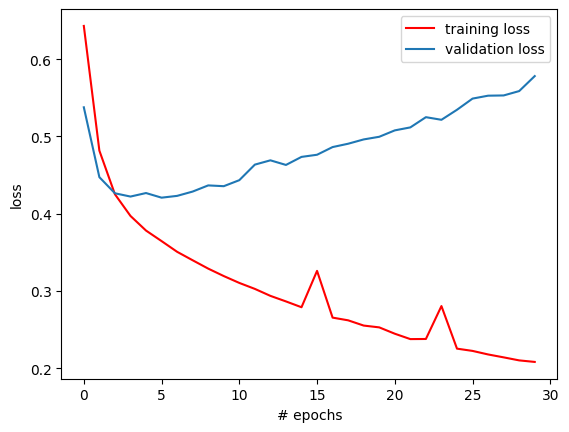

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

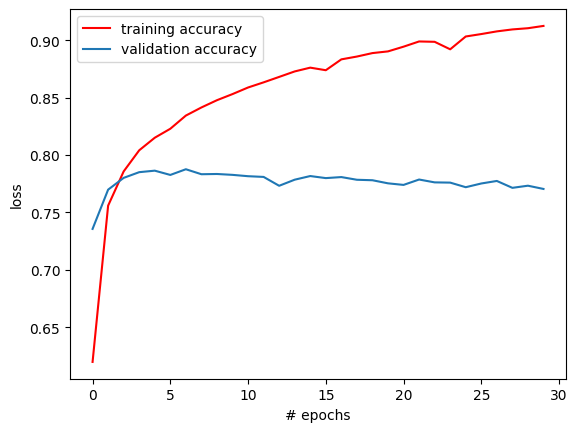

In [ ]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = best_model.evaluate(test_sequences_matrix,y_test)
print(accr)

756/756 [==============================] - 62s 82ms/step - loss: 0.5766 - accuracy: 0.7709
[0.5765986442565918, 0.7709099650382996]


prediction


In [ ]:
lstm_prediction=model.predict(test_sequences_matrix)

756/756 [==============================] - 74s 98ms/step


In [ ]:
res=[]
for prediction in lstm_prediction:
    if prediction[0]<0.5:
        res.append(0)
    else:
        res.append(1)

In [ ]:
print(confusion_matrix(y_test,res))

[[11170  2299]
 [ 2904  7814]]


In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model.save("hate&abusive_model.h5")

In [ ]:
import keras

In [ ]:
load_model=keras.models.load_model("/content/hate&abusive_model.h5")
with open('/content/tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [ ]:

def clean_text(text):
    print(text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
test = 'i love you  '
test=[clean_text(test)]
# print(test)
seq = load_tokenizer.texts_to_sequences(test)
padded =pad_sequences(seq, maxlen=300)
# print(seq)
pred = load_model.predict(padded)
print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hate and abusive")

i love you  
i love you  
1/1 [==============================] - 0s 250ms/step
pred [[0.4541662]]
no hate
